# Preference

Make a table (or graph) of method preferences using coherence scores.

Use compliance adjusted scores or drop non-compliant cases...

Validate the table with measure of agreement with the finetuning results (see the interannotator agreement notebook for the preference agreement calculations and simulations).

### Plot/Table

In [1]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar 
import seaborn as sns
import scipy.stats as stats
import simpledorff
import math
import itertools


In [2]:
# Load plot_settings.pickle
import pickle

with open('order_list.pkl', 'rb') as f:
    order_list = pickle.load(f)
print(order_list)

with open('hue_order_gsm8k.pkl', 'rb') as f:
    hue_order_gsm8k = pickle.load(f)
print(hue_order_gsm8k)

with open('hue_order_cw.pkl', 'rb') as f:
    hue_order_cw = pickle.load(f)
print(hue_order_cw)

with open('hue_order_introduced.pkl', 'rb') as f:
    hue_order_introduced = pickle.load(f)
print(hue_order_introduced)

# Set the font to Times New Roman or a similar serif font
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
# Optionally, set the font size
mpl.rcParams['font.size'] = 12

# Figure size
f_size = (16 / 2, 9 / 2)

# print(plot_settings.keys())
# order_list = plot_settings['order_list']
# hue_order_gsm8k = plot_settings['hue_order_gsm8k']
# hue_order_cw = plot_settings['hue_order_cw']

# Set up latex rendering
# import matplotlib.pyplot as plt
# import matplotlib as mpl

# Enable LaTeX rendering
#mpl.rcParams['text.usetex'] = True


['Text-Davinci-003', 'GPT-4']
['Manual Few-Shot', 'Manual CoT', 'Least-to-Most', 'Zero-Shot CoT', 'APE Zero-Shot CoT', 'Self-Refine', 'Tree-of-Thought', 'Direct Prompting']
['Manual Few-Shot', 'Manual CoT', 'Least-to-Most', 'Zero-Shot CoT', 'APE Zero-Shot CoT', 'Self-Refine', 'Tree-of-Thought', 'Direct Prompting']
['Direct Prompting', 'Zero-Shot CoT', 'APE Zero-Shot CoT', 'Tree-of-Thought', 'Self-Refine', 'Least-to-Most', 'Manual Few-Shot', 'Manual CoT']


In [3]:
# Load Combined_Data.xlsx
combined_data = pd.read_excel('Combined_Data.xlsx')

# GSM8k data - limit to task = "gsm8k"
gsm8k_data = combined_data[combined_data['task'] == 'gsm8k']

# Creative writing data - limit to task = "cw"
cw_data = combined_data[combined_data['task'] == 'cw']

# Load direct_prompting_comparison.xlsx
direct_prompting_comparison = pd.read_excel('direct_prompting_comparison.xlsx')


In [4]:
print(cw_data.columns)


Index(['model_task_method', 'conversation_number',
       'coherence_1_incoherent_10_very_coherent',
       'task_constraints_followed_0_not_followed_1_followed',
       'ease_of_review_1_easy_10_hard', 'correct',
       'Prediction_Based_On_First_10', 'Prediction_Based_On_Last_10',
       'Aggregated_Prediction', 'Prediction_Based_On_First_10_LP',
       'response_Based_On_First_10_LP', 'Prediction_Based_On_Last_10_LP',
       'response_Based_On_Last_10_LP', 'response_LP',
       'Aggregated_Prediction_LP', 'Prediction_Based_On_First_50_LP',
       'response_Based_On_First_50_LP', 'Prediction_Based_On_Last_50_LP',
       'response_Based_On_Last_50_LP', 'Aggregated_Prediction_50_LP',
       'Prediction_Based_On_random_50_LP_1',
       'response_Based_On_random_50_LP_1',
       'Prediction_Based_On_random_50_LP_2',
       'response_Based_On_random_50_LP_2',
       'Aggregated_Prediction_random_50_LP', 'Unnamed: 0_x', 'response_x',
       'replace_slash_n_slash_n_with_newline_x',
       

In [5]:
# Variables to run for
vars_to_make_preference_table_for = [
    'coherence_1_incoherent_10_very_coherent'
    , 'coherence_1_incoherent_10_very_coherent_compliance_adjusted'
    ]


max_scores
                Model  conversation_number  \
0               GPT-4                    1   
1               GPT-4                    2   
2               GPT-4                    3   
3               GPT-4                    4   
4               GPT-4                    5   
..                ...                  ...   
195  Text-Davinci-003                   96   
196  Text-Davinci-003                   97   
197  Text-Davinci-003                   98   
198  Text-Davinci-003                   99   
199  Text-Davinci-003                  100   

     coherence_1_incoherent_10_very_coherent  
0                                        9.0  
1                                        9.0  
2                                        8.0  
3                                        8.0  
4                                        9.0  
..                                       ...  
195                                      9.0  
196                                      6.0  
197          

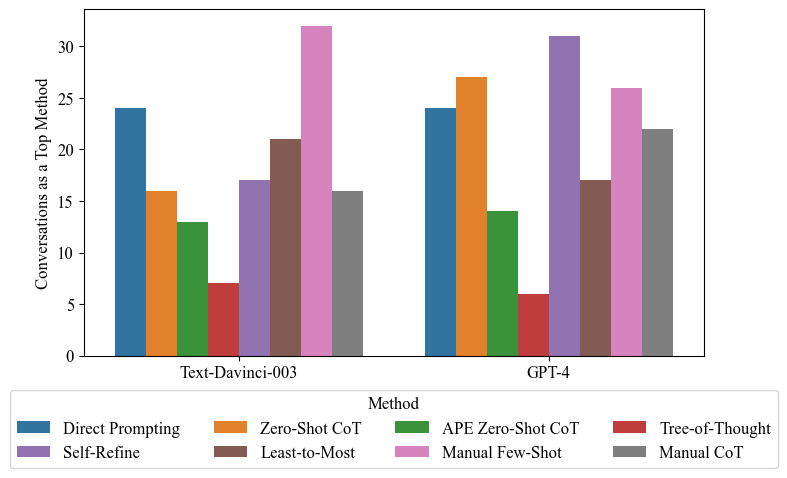

output_mmc
               Model             Method  Conversations as a Top Method
0   Text-Davinci-003    Manual Few-Shot                             32
1                      Direct Prompting                             24
2                         Least-to-Most                             21
3                           Self-Refine                             17
4                            Manual CoT                             16
5                         Zero-Shot CoT                             16
6                     APE Zero-Shot CoT                             13
7                       Tree-of-Thought                              7
8              GPT-4        Self-Refine                             31
9                         Zero-Shot CoT                             27
10                      Manual Few-Shot                             26
11                     Direct Prompting                             24
12                           Manual CoT                           

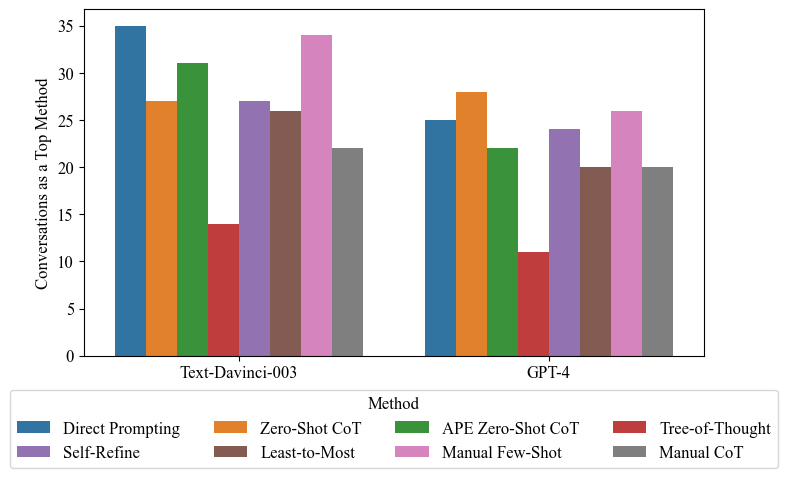

output_mmc
               Model             Method  Conversations as a Top Method
0   Text-Davinci-003   Direct Prompting                             35
1                       Manual Few-Shot                             34
2                     APE Zero-Shot CoT                             31
3                           Self-Refine                             27
4                         Zero-Shot CoT                             27
5                         Least-to-Most                             26
6                            Manual CoT                             22
7                       Tree-of-Thought                             14
8              GPT-4      Zero-Shot CoT                             28
9                       Manual Few-Shot                             26
10                     Direct Prompting                             25
11                          Self-Refine                             24
12                    APE Zero-Shot CoT                           

In [6]:
# Make preference table

# Loop over variables
for variable in vars_to_make_preference_table_for:

    # By Model and conversation_number, get values of Method that are maxes
    max_scores = cw_data.groupby(['Model', 'conversation_number'])[variable].max().reset_index()

    print('max_scores')
    print(max_scores)

    # Create df with Model, conversation_number, Method, and max_score
    preferred_method_df = pd.merge(cw_data[['Model', 'Method', 'conversation_number', variable]], max_scores, on=['Model', 'conversation_number', variable], how='inner')

    print('preferred_method_df')
    print(preferred_method_df)

    # Get counts by model, method
    model_method_counts = preferred_method_df[['Model', 'Method', 'conversation_number']].groupby(['Model', 'Method']).count()
    # Rename variable column to count
    model_method_counts = model_method_counts.rename(columns={'conversation_number': 'Conversations as a Top Method'}).sort_values(by = ['Model', 'Conversations as a Top Method'], ascending=False)

    # Flatten columns
    model_method_counts = model_method_counts.reset_index()

    # Produce plot
    plt.figure(figsize=f_size)
    sns.barplot(x='Model', y='Conversations as a Top Method', hue='Method', hue_order=hue_order_introduced, data=model_method_counts, order=order_list)
    #sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
    #plt.xlabel('')
    # plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
    #plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
    # No x axis title
    plt.gca().set_xlabel('')
    plt.gca().set_ylabel('Conversations as a Top Method')#, fontsize=fontsize_cw)
    # Put legend centered below plot area
    #plt.legend(title = 'Method', loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=4)
    # Create legend filling rows first
    def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])
    handles, labels = plt.gca().get_legend_handles_labels()
    num_cols = 4
    plt.legend(flip(handles, num_cols), flip(labels, num_cols), title = 'Method', loc='upper center', bbox_to_anchor=(0.5, -0.075), ncol=num_cols)
    # Put legend to the right of the plot
    #plt.legend(title = 'Method', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
    #plt.title('Human Creative Writing Coherence Preferences - Compliance Adjusted')#, pad=title_pad)
    #plt.title('Human Creative Writing Coherence Preferences - Compliance Adjusted')
    plt.savefig('../Output/cw_preference_plot_' + variable + '.png', bbox_inches='tight')
    plt.show()
    plt.close()

    # Set model to blank if it's not the first row for that model
    output_mmc = model_method_counts.copy()
    output_mmc['Model'] = output_mmc['Model'].where(output_mmc['Model'] != output_mmc['Model'].shift(), '')

    print('output_mmc')
    print(output_mmc)

    # Output to LaTeX
    # Center columns
    output_mmc.to_latex('../Output/cw_preference_table_' + variable + '.tex', index=False, column_format='c c c')

    # Keep rows that are the highest count for their model
    most_preferred_methods = model_method_counts.reset_index()
    most_preferred_methods = most_preferred_methods.sort_values(by=['Conversations as a Top Method'], ascending=False)
    most_preferred_methods = most_preferred_methods.drop_duplicates(subset=['Model'], keep='first')

    print('most_preferred_methods')
    print(most_preferred_methods)

    # Output to LaTeX
    most_preferred_methods.to_latex('../Output/cw_most_preferred_methods_' + variable + '.tex', index=False, column_format='c c c')


### Agreement Statistics and Test